# Ford GoBike (Bike Shares) Records Exploring

## Investigation Overview

In this investigation , I am interested to figure out the Top stations with highest Trip records and the average trip durations among those stations. in addition, I will explore other characteristics that could have an effect or relationships with the mention features of interest. Characteristics related to time like weekdays & day time) and others related to riders like ages , gender and user Type.

## Dataset Overview

The data consisted of bikes' trip records and attributes of 183412 Bikes' rental records for February 2019 in San Francisco with mainly 9 features (start_station_name, end_station_name, weekday, start_hour, bike_share_for_all_trip, member_gender, member_age(years), user_type and duration_min(min)).
Most variables are Categorical, but the variables member_age(years) and duration_min(min) are numeric variables.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
import calendar

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe, print statistics
df_orgin = pd.read_csv('201902-fordgobike-tripdata.csv')

In [3]:
# fixing NAN stations name  & id

#gathering coordinates(latitude) of Null station ids 
null_start_stations_latitude = df_orgin.loc[df_orgin['start_station_id'].isnull()]['start_station_latitude'].value_counts().index
null_end_stations_latitude = df_orgin.loc[df_orgin['end_station_id'].isnull()]['end_station_latitude'].value_counts().index

#all available start/end stations_coordinates(Latitude)

start_stations_coordinates = df_orgin.loc[df_orgin['start_station_id'].dropna()]['start_station_latitude'].drop_duplicates().values
end_stations_coordinates = df_orgin.loc[df_orgin['end_station_id'].dropna()]['end_station_latitude'].drop_duplicates().values

In [4]:
def get_nearest_station(null_stations_latitude,stations_coordinates):    
    station_mapping = {}

    for i in null_stations_latitude:
        lowset_diff_loc = 1000
        nearst_loc = 0
        for x in stations_coordinates:
            current_diff_loc = abs(x - i)
            if current_diff_loc < lowset_diff_loc:
                lowset_diff_loc = current_diff_loc
                nearst_loc = x
        station_mapping[i]= nearst_loc
    return station_mapping

In [5]:
#Data cleaning

nearst_start_station = get_nearest_station(null_start_stations_latitude,start_stations_coordinates)
nearst_end_station = get_nearest_station(null_end_stations_latitude,end_stations_coordinates)
df_start_station = df_orgin.query('start_station_latitude == 37.33839520000001')[['start_station_id','start_station_name']].drop_duplicates().reset_index(drop=True)
df_end_station =df_orgin.query('end_station_latitude == 37.352886827291215')[['end_station_id','end_station_name']].drop_duplicates().reset_index(drop=True)
#filling NAN stations name  & id

df_orgin['start_station_id'].fillna(value=df_start_station.loc[0,'start_station_id'] ,inplace=True)
df_orgin['start_station_name'].fillna(value=df_start_station.loc[0,'start_station_name'],inplace=True)
df_orgin['end_station_id'].fillna(value=df_end_station.loc[0,'end_station_id'],inplace=True)
df_orgin['end_station_name'].fillna(value=df_end_station.loc[0,'end_station_name'],inplace=True)
# fixing NAN birth year  & gender

#get the median of thr birth year  & highest counts of gender for each start station 

df_birth = df_orgin.groupby(['start_station_id']).median()['member_birth_year']

df_gender = df_orgin.groupby(['start_station_id','member_gender']).count()['member_birth_year'].sort_values(ascending=False).reset_index()
df_gender = df_gender.loc[df_gender['start_station_id'].drop_duplicates().index].set_index('start_station_id')['member_gender']
# fixing NAN birth year  & gender
df_orgin['member_birth_year'] = [df_birth.loc[i] if pd.isnull(x) else x for i,x in zip (df_orgin['start_station_id'] ,df_orgin['member_birth_year'])]
df_orgin['member_gender'] = [df_gender.loc[i] if pd.isnull(x) or x == 'Other'  else x for i,x in zip (df_orgin['start_station_id'] ,df_orgin['member_gender'])]
# convert dtype of start_time , end time coloumns need to be converted to datetime
df_orgin['start_time'] = pd.to_datetime(df_orgin['start_time'])
df_orgin['end_time'] = pd.to_datetime(df_orgin['end_time'])

# convert dtype of member_birth_year coloumn need to be converted to integer

df_orgin['member_birth_year'] = df_orgin['member_birth_year'].astype(int).astype('Int64')
df_orgin['start_station_id'] = df_orgin['start_station_id'].astype('Int64')
df_orgin['end_station_id'] = df_orgin['end_station_id'].astype('Int64')



In [6]:
#Features extraction

# convert duration_sec for each record into hours based
# get weekday , hour for each record from date
# get member Age from date and member_birth_year

df_orgin['duration_hour(hrs)'] = round(df_orgin['duration_sec']/3600 ,2)
df_orgin['duration_min(min)'] = round(df_orgin['duration_sec']/60 ,2)

df_orgin['weekday'] = df_orgin['start_time'].dt.dayofweek
df_orgin['weekday'] = [calendar.day_name[i] for i in df_orgin['weekday']]

df_orgin['start_hour'] = df_orgin['start_time'].dt.hour.astype('category')
df_orgin['start_station_id'] = df_orgin['start_station_id'].astype('category')
df_orgin['end_station_id'] = df_orgin['start_station_id'].astype('category')

df_orgin['member_age(years)'] = df_orgin['start_time'].dt.year - df_orgin['member_birth_year'] 

#creating our dataframe with important features

df = df_orgin.copy()
df = df[['start_station_id','start_station_name','end_station_id','end_station_name','weekday','start_hour',
       'bike_share_for_all_trip' , 'member_gender', 'member_age(years)','user_type' ,'duration_hour(hrs)','duration_min(min)']]
    

## Distribution of Trips Durations(min)

Distributions of Bikes Trip durations under logarithmic Scale are most likely normally distributed and mean of trips durations is around 9 minutes. there are few records (outliers) of trip duration more than 200min.

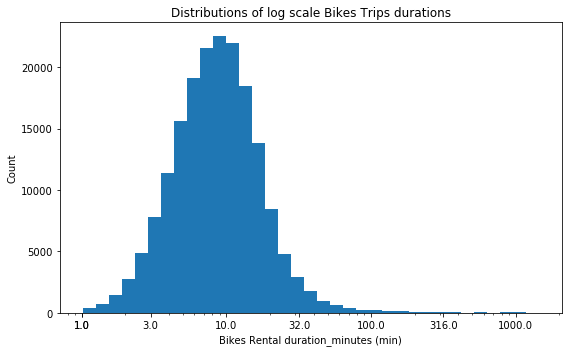

In [7]:
# there's a long tail in the distribution, so let's put it on a log scale instead

log_binsize = 0.09
bins = 10 ** np.arange(0.0086, np.log10(df['duration_min(min)'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'duration_min(min)', bins = bins)
plt.xscale('log')
ticks= np.array([1, round(10**0,0),round(10**0.5,0),round(10**1,0),round(10**1.5,0),round(10**2,2),round(10**2.5,0),round(10**3,0)])
plt.xticks(ticks, ticks)
plt.xlabel('Bikes Rental duration_minutes (min)')
plt.ylabel('Count')
plt.title('Distributions of log scale Bikes Trips durations');

plt.tight_layout()
plt.show()

## Distribution of of riders' Ages(years)

Distributions of riders' Ages under logarithmic Scale are most likely normally distributed and and most of riders' ages are around 32 years old. There are few records (outliers) of memebers' ages more than 100 years old.

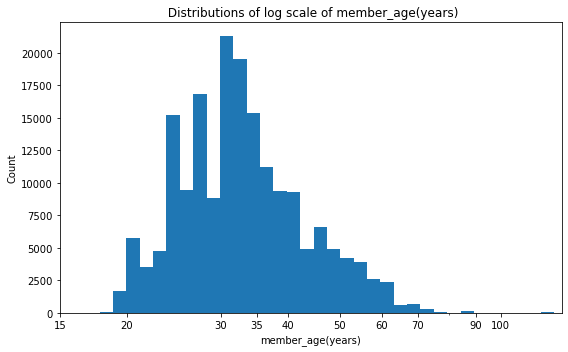

In [8]:
# there's a long tail in the distribution, so let's put it on a log scale instead

log_binsize = 0.025
bins = 10 ** np.arange(1, np.log10(df['member_age(years)'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'member_age(years)', bins = bins)
plt.xscale('log')
ticks= np.array([15,20,30,35,40,50,60 ,70,90,100])
plt.xticks(ticks, ticks)
plt.xlim(15,130)
plt.xlabel('member_age(years)')
plt.ylabel('Count')
plt.title(' Distributions of log scale of member_age(years)');

plt.tight_layout()
plt.show()

## Bikes Rents Distributions across Weedays & Day hours

- Bikes rentals on workdays are approximatly double the rentals during weekends.it is more likely it is due to working schedule. The highest Bikes rentals are on Thursday.
- Bikes rentals have 2 peak intervals during the day.
    - 1st Peak interval 2 hours in morning between 08:00am to 10:00am. it's more likely that riders are going to their work.
    - 2nd peak interval 32 hours in evening between 04:00pm to 07:00pm. it's more likely that riders are returning from their work.

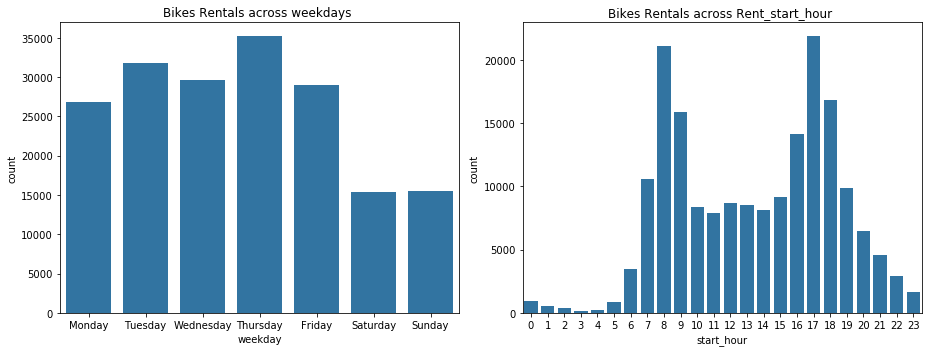

In [9]:

df = df[df['member_age(years)']< 100]
# exploring Bikes Rents across weekdays
# exploring Bikes Rents across start_hour

plt.figure(figsize= (13,5))

plt.subplot(1,2,1)
default_color = sns.color_palette()[0]
ordinal_weekdays = list(calendar.day_name)
sns.countplot(data= df_orgin , x = 'weekday' ,order= ordinal_weekdays , color = default_color );
plt.title('Bikes Rentals across weekdays ');

plt.subplot(1,2,2)

sns.countplot(data= df_orgin , x = 'start_hour' , color = default_color );
plt.title('Bikes Rentals across Rent_start_hour ');
plt.tight_layout()
plt.show()

## Top 7 stations with highest Traffic(trips)

Below are Top 7 stations out of 329 start stations having the highest number of trips more than 2500. where 'Market St at 10th St' station has the highest number of trips. our comming analysis will be based on these Top 7 stations (highest traffic stations).

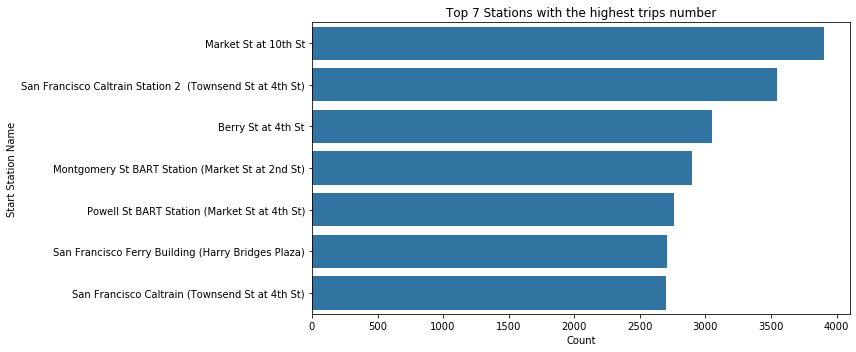

In [10]:
stations = df['start_station_name'].value_counts().reset_index().rename(columns={'index':'start_station_Name','start_station_name':'trips count'}).iloc[:50]
#gathering top
top_locs =stations.iloc[:7]
top_locs
#filtering our data frame on the Top 7 stations where rest of our anlysis will be based on these stations

top_locs_list = top_locs['start_station_Name'].tolist()
df_top_locs = df.loc[df['start_station_name'].isin(top_locs_list)]

plt.figure(figsize=[12, 5])
sns.countplot(data= df_top_locs, y='start_station_name', color=default_color, order= top_locs_list)
plt.xlabel('Count')
plt.ylabel('Start Station Name')
plt.title('Top 7 Stations with the highest trips number');
plt.tight_layout();
plt.show();


## Average Trip Duration per the Top 7 Station

we can observe that the average trip duration for 'San Francisco Ferry Building' is the longest trip with duration pf 14 minutes.

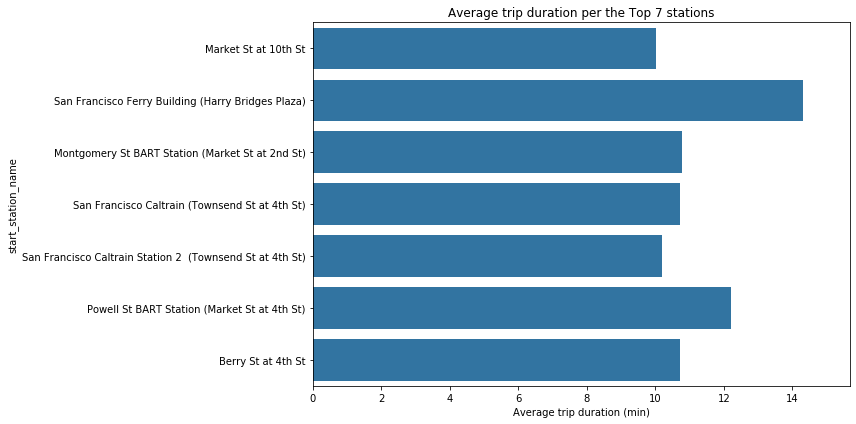

In [11]:
# Plot the mean trip duration per top 7 station using bar chart
df_top_rmv_outliers = df_top_locs.loc[df_top_locs['duration_min(min)'] < 200]
plt.figure(figsize=(12,6))
bins = np.arange(0, df_top_rmv_outliers['duration_min(min)'].max()+2, 2)
sns.barplot(x='duration_min(min)' , y='start_station_name' , data = df_top_rmv_outliers , color = default_color ,errwidth=0 )
#sns.boxplot(data = df_top_rmv_outliers , y = 'duration_min(min)' , x = 'start_station_id' );
# plt.xlim((0,50))
plt.xlabel('Average trip duration (min)')
plt.title('Average trip duration per the Top 7 stations' )

plt.tight_layout();

## Trip Duration vs. Memeber Age 

Age has slight negative correlation with Trip duration.Assumed that older ages riders can not ride for long distance.


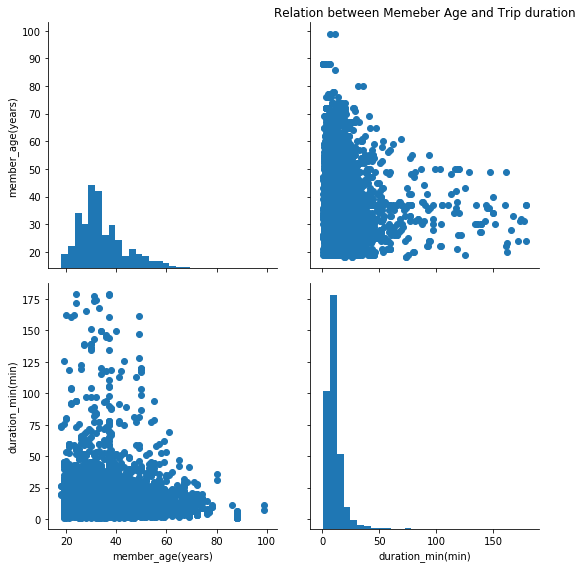

In [12]:
# correlation plot Relation between Memeber Age and Trip duration using pairgrid with scatter plot
df_top_rmv_outliers = df_top_locs.loc[df_top_locs['duration_min(min)'] < 200]
numerical_vars = ['member_age(years)', 'duration_min(min)']

g = sns.PairGrid(data = df_top_rmv_outliers, vars = numerical_vars , height = 4)
g = g.map_diag(plt.hist, bins = 30);
g.map_offdiag(plt.scatter )
plt.title('Relation between Memeber Age and Trip duration');
plt.tight_layout();
plt.show();

## Day time & Week days trips among The Top 7 stations

**Day Time:**
   - the station with the peak/top number of trips in morning is 'San Francisco Caltrain Station 2', which seems it is more likely a perfect start point to rent a bike and ride to work place as it is near to Caltrain station.
   - while the stations with the peak/top number of trips in evening are 'Montgomery St BART Station' & 'Powell St BART Station'. I am assuming people using these stations are more likely are returning from work places.
    
**Week days:**
   - 'Thursday' has the highest trips number among all weekdays on all stations.
   -  'Market St at 10th St' & 'Powell St BART Station'have higher trips number during weekends than other stations. mostly there are good places near to those station to go during holidays.

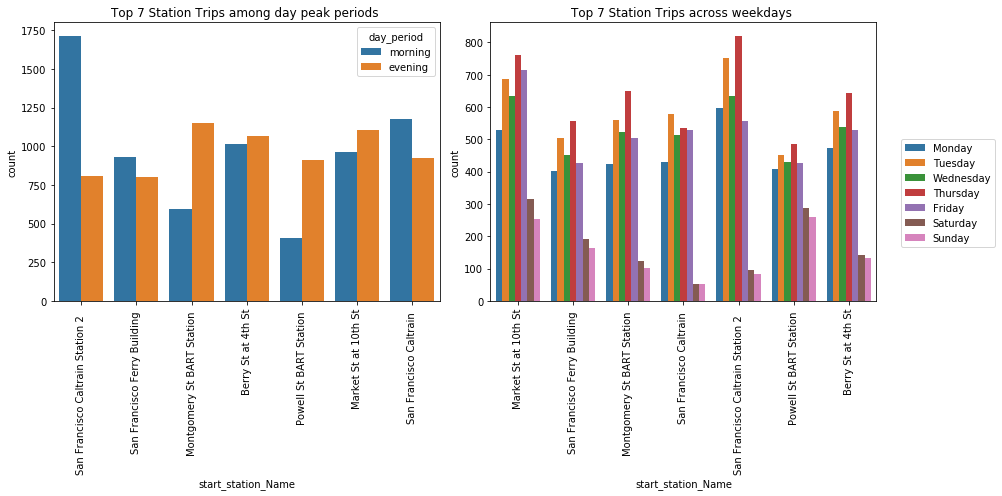

In [13]:
# Preproccessing and preparations steps for Categoricals features before plottings 

# due to long name of stations we can extract first part of stations name
df_top_rmv_outliers['start_station_Name'] = [i.split("(")[0] for i in df_top_rmv_outliers['start_station_name']]
df_top_rmv_outliers['start_station_Name'].value_counts()

# dividing rentals' start hour in to 2 Catagoricals [morning & evening] => peak durations

df_top_rmv_outliers['day_period'] = 'day_normal_hours'
df_top_rmv_outliers['day_period'].loc[df_top_rmv_outliers['start_hour'].isin((7,8,9))]= 'morning'
df_top_rmv_outliers['day_period'].loc[df_top_rmv_outliers['start_hour'].isin((16,17,18))] = 'evening'

#df_top_rmv_outliers['day_period'].value_counts()
#df_top_rmv_outliers['start_station_Name'].value_counts()
# plotting distributions of time (morning and evening peak hours) & (weekdays)  among stations => 2 Categoricals 

plt.figure(figsize= (14,7))

plt.subplot(1,2,1)

ordinal_weekdays = list(calendar.day_name)
df_ =df_top_rmv_outliers.loc[df_top_rmv_outliers['day_period'].isin(('morning','evening'))]

sns.countplot(data= df_ , x = 'start_station_Name' , hue = 'day_period' ,hue_order=['morning','evening'] );
plt.title('Top 7 Station Trips among day peak periods ');
plt.xticks(rotation = 90)
plt.subplot(1,2,2)
#plt.figure(figsize= (9,6))

ordinal_weekdays = list(calendar.day_name)
sns.countplot(data= df_top_rmv_outliers , x = 'start_station_Name' ,hue_order= ordinal_weekdays , hue = 'weekday' );
plt.title('Top 7 Station Trips across weekdays ');
plt.legend( bbox_to_anchor = (1.05, 0.6))
plt.xticks(rotation = 90)

plt.tight_layout()
plt.show()


## Riders' gender & User Type among The Top 7 Stations

- Most of the riders for the top7 stations are subscribers(more than 95%).
- the Male riders for the top7 stations are much higher than female riders (approximatly 1.5 to 2 times the Female riders)

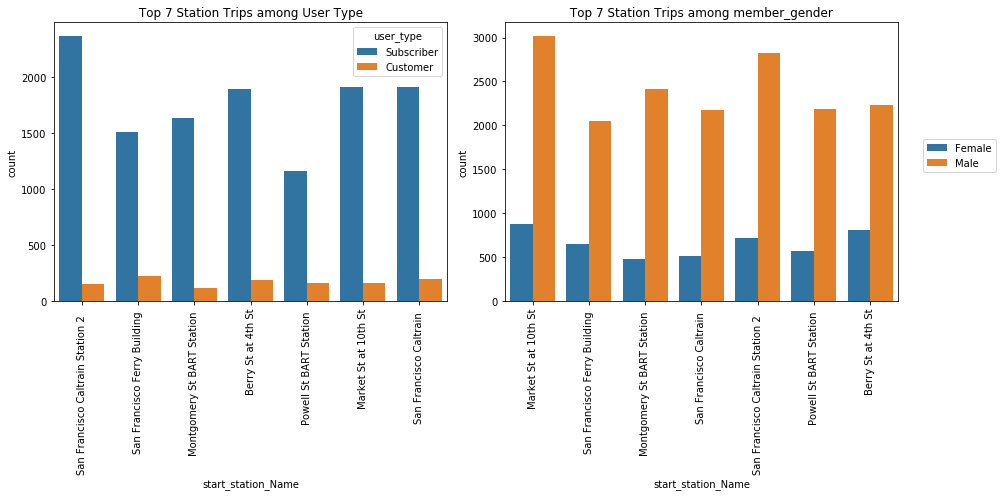

In [14]:
# plotting distributions of user type & member gender among stations => 2 Categoricals 

plt.figure(figsize= (14,7))

plt.subplot(1,2,1)

sns.countplot(data= df_ , x = 'start_station_Name' , hue = 'user_type');
plt.title(' Top 7 Station Trips among User Type ');
plt.xticks(rotation = 90)
plt.subplot(1,2,2)
#plt.figure(figsize= (9,6))

sns.countplot(data= df_top_rmv_outliers , x = 'start_station_Name' , hue = 'member_gender' );
plt.title(' Top 7 Station Trips among member_gender ');
plt.legend( bbox_to_anchor = (1.05, 0.6))
plt.xticks(rotation = 90)

plt.tight_layout()
plt.show()

## Riders' Gender & User Type among The Top 7 Stations

- Average trip duration during weekend is longer than normal week days.
- Average riders ages and it's distributions in weekends are younger than riders ages during normal week days mostly related to family trips during holidays.
- Average ages of male riders are older than female rider.
- Average Trip duration for females are slightly longer than males.

In [15]:
# compute the logarithm of age & trip durations to make multivariate plotting easier

def log_trans(x, inverse = False):
    """ quick function for computing log and power operations """
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10, x)

df_top_rmv_outliers['log_duration_min'] = df_top_rmv_outliers['duration_min(min)'].apply(log_trans)
df_top_rmv_outliers['log_member_age(years)'] = df_top_rmv_outliers['member_age(years)'].apply(log_trans)


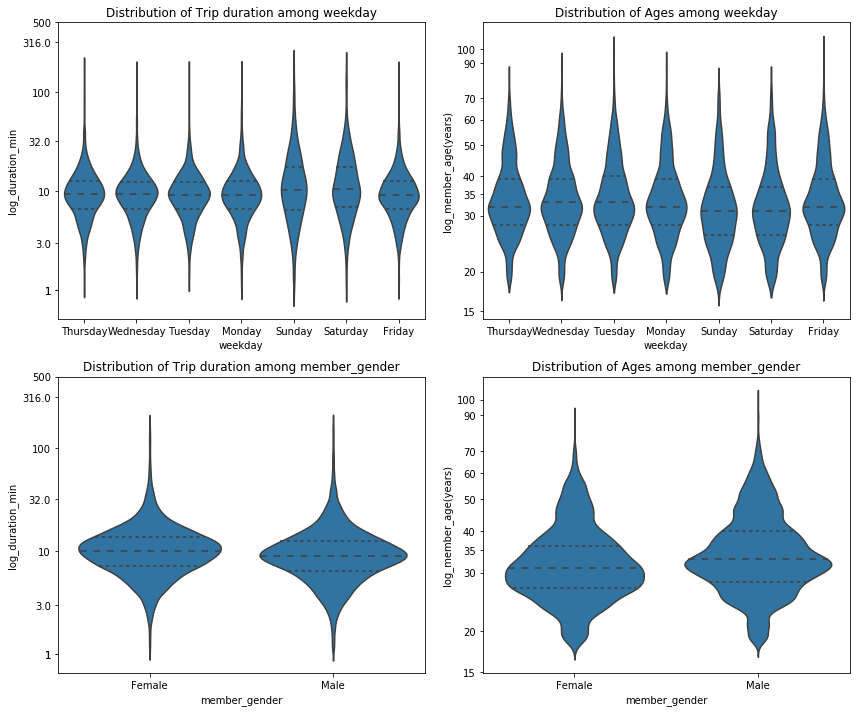

In [16]:
# plot the categorical variables against age & trip durations for explantory part


categoric_vars = [ 'weekday','member_gender']

fig, ax = plt.subplots(ncols = 2, nrows = 2 , figsize = [12,10])

for i in range(len(categoric_vars)):
    var = categoric_vars[i]
    sns.violinplot(data = df_top_rmv_outliers, x = var, y = 'log_duration_min', ax = ax[i,0],
               color = default_color ,inner='quartile')
    yticks = [1, round(10**0,0),round(10**0.5,0),round(10**1,0),round(10**1.5,0),round(10**2,2),round(10**2.5,0),round(500,0)]
    ax[i,0].set_yticks(log_trans(np.array(yticks)))
    ax[i,0].set_yticklabels(yticks)
    ax[i,0].set_title(f'Distribution of Trip duration among {var}')

    sns.violinplot(data = df_top_rmv_outliers, x = var, y = 'log_member_age(years)', ax = ax[i,1],
               color = default_color ,inner='quartile')
    ax[i,1].set_yticks(log_trans(np.array([15,20,30,35,40,50,60 ,70,90,100])))
    ax[i,1].set_yticklabels([15,20,30,35,40,50,60 ,70,90,100])
    ax[i,1].set_title(f'Distribution of Ages among {var}')

plt.tight_layout()
plt.show()

## Trip Durations among Weekdays per Gender

Average Trip duration for females are slightly longer than males for all weekdays. More likely that it is related to physical performance of males are better than female as nature.

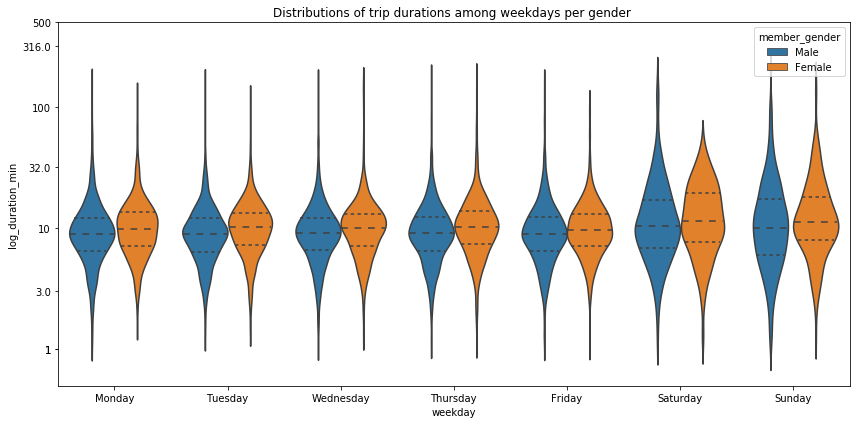

In [17]:
plt.figure(figsize=(12,6))

sns.violinplot(data = df_top_rmv_outliers, x = 'weekday', y = 'log_duration_min',hue= 'member_gender', hue_order=['Male','Female'],
                order= ordinal_weekdays,inner='quartile')
yticks = [1, round(10**0,0),round(10**0.5,0),round(10**1,0),round(10**1.5,0),round(10**2,2),round(10**2.5,0),round(500,0)]
plt.yticks(log_trans(np.array(yticks)) , yticks)

#plt.ylabel(yticks)

plt.title('Distributions of trip durations among weekdays per gender ')

plt.tight_layout()
plt.show()

## Trip Durations among Weekdays per User Type

Average trip duration for customers are longer than for subscribers and more longer during weekends. Assume that families (who are mostly are customers) are enjoying riding during holidays.

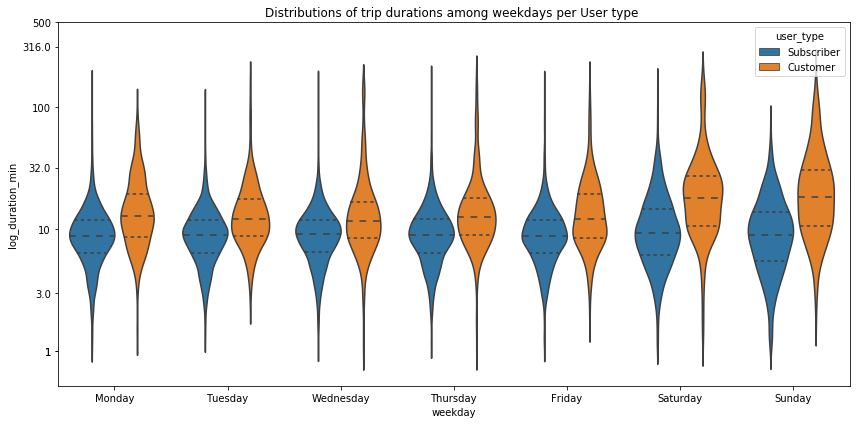

In [18]:

plt.figure(figsize=(12,6))

sns.violinplot(data = df_top_rmv_outliers, x = 'weekday', y = 'log_duration_min',hue= 'user_type',order= ordinal_weekdays,
                inner='quartile')
yticks = [1, round(10**0,0),round(10**0.5,0),round(10**1,0),round(10**1.5,0),round(10**2,2),round(10**2.5,0),round(500,0)]
plt.yticks(log_trans(np.array(yticks)) , yticks)

#plt.ylabel(yticks)

plt.title('Distributions of trip durations among weekdays per User type ')

plt.tight_layout()
plt.show()

In [19]:
!jupyter nbconvert Project_3_FordGoBike-dataset_Part2.ipynb --to slides --post serve --no-input --no-prompt


[NbConvertApp] Converting notebook Project_3_FordGoBike-dataset_Part2.ipynb to slides
[NbConvertApp] Writing 861361 bytes to Project_3_FordGoBike-dataset_Part2.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Traceback (most recent call last):
  File "C:\Users\Thinkpad\anaconda3\envs\DataCamp\Scripts\jupyter-nbconvert-script.py", line 10, in <module>
    sys.exit(main())
  File "C:\Users\Thinkpad\anaconda3\envs\DataCamp\lib\site-packages\jupyter_core\application.py", line 270, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "C:\Users\Thinkpad\anaconda3\envs\DataCamp\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "C:\Users\Thinkpad\anaconda3\envs\DataCamp\lib\site-packages\nbconvert\nbconvertapp.py", line 340, in start
    self.convert_notebooks()
  File "C:\Users\Thinkpad\anaconda3\envs\DataCamp\lib\site-packages\nb